## Goal

- Implement a minimal autograd engine and neural network library in pure Python, following Andrej Karpathy's Micrograd project.

In [15]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

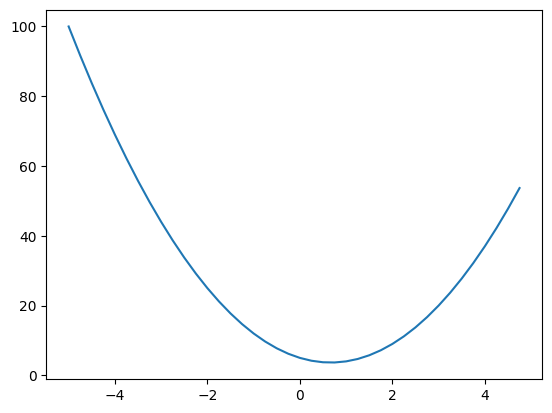

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [5]:
h = 0.0000001
x = 3.0
(f(x + h) - f(x)) / h # this give the slope at x=3.0

14.000000305713911

In [6]:
h = 0.0000001
x = -3.0
(f(x + h) - f(x)) / h # this give the slope at x=3.0

-21.999999688659955

In [7]:
# lets get a bit more complex. Let's look at the derivative of d based on a, b, c
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [8]:
# here we test by changing one of the inputs (a, b or c) by a small h. then we check the result before and after the change
h = 0.001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
b += h 
d2 = a*b + c

print('d1:', d1)
print('d2:', d2)
print(f'Slope: {(d2 - d1) / h}')

d1: 4.0
d2: 4.002
Slope: 1.9999999999997797


In [9]:
class BasicValue:
    def __init__(self, data):
        self.data = data
    def __repr__(self):
        return f'BasicValue(data={self.data})'
    def __add__(self, other):
        out = BasicValue(self.data + other.data)
        return out
    def __mul__(self, other):
        out = BasicValue(self.data * other.data)
        return out
    
a = BasicValue(2.0)
b = BasicValue(-3.0)
c = BasicValue(10.0)
print(a + b)
print(a * c)
# now do the same as above when computing d
print(a * b + c)

BasicValue(data=-1.0)
BasicValue(data=20.0)
BasicValue(data=4.0)


In [16]:
# Now we are missing the connective tissue between each evaluation. We want to keep the expression graphs so we need to store references to the children nodes. We need to know what value produce what other value. So we add children (ie parent nodes) to the Value class
# After that we want to know what operation produced the value so we add that as well.
class Value:
    def __init__(self, data, _children=(), _op='', label=''):  # for convenience, this is a Tuple but we transform it into a set for efficiency
        self.data = data
        self.grad = 0.0  # this will hold the gradient value later during backpropagation. start at 0 when created
        self._backward = lambda: None  # function who by default doesn't do anything but to be defined later during backpropagation
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f'Value(data={self.data})'
    
    # self + other
    def __add__(self, other): 
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out
    
    # self * other
    def __mul__(self, other): 
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only support int/float for now"
        out = Value(self.data**other, (self, ), f'**{other}')

        def _backward():
            self.grad += other * (self.data  ** (other - 1)) * out.grad
        out._backward = _backward

        return out
    
    # other * self (not found)
    def __rmul__(self, other):
        return self * other
    
    # self / other (because a / b = a * (1/b) = a * b**-1)
    def __truediv__(self, other):
        return self * other**-1
    
    # -self
    def __neg__(self): 
        return self *-1
    
    # self - other
    def __sub__(self, other): 
        return self + (-other)
    
    # other + self
    def __radd__(self, other): 
        return self + other

    def tanh(self):
        x = self.data
        t = math.tanh(x) #(math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
    
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out


    # Topological sort/backpropagation. This method will check a value if it wasn't visited, it mark it as visited then call itself on each of the value's children, then later append the value to the topo list.
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()






# a = Value(2.0, label='a')
# b = Value(-3.0, label='b')
# c = Value(10.0, label='c')
# # now do the same as before when we computed d
# e = a * b; e.label='e'
# d = e + c; d.label='d'
# f = Value(-2.0, label='f')
# L = d * f; L.label='L'
# print(d)

In [11]:
print(f'Children nodes of d: {d._prev}')
print(f'Children nodes of d first child: {list(d._prev)[0]._prev}')

AttributeError: 'float' object has no attribute '_prev'

In [ ]:
print(f'Operation used to create d: {d._op}')
print(f'Operation used to create d first child: {list(d._prev)[0]._op}')

Operation used to create d: +
Operation used to create d first child: *


In [17]:
# Now we want to be able to vizualize the computation graph. For that we will use graphviz (an open source visualization tool).
from graphviz import Digraph
import os
gv = r'C:\Program Files\Graphviz\\bin'   # update if your Graphviz is elsewhere
os.environ['PATH'] = os.environ.get('PATH','') + os.pathsep + gv

def trace(root):
    # build a set of all nodes and edges in a graph
    nodes, edges= set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir':'LR'})  # LR: left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a box node for it
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid + n._op, label=f'{n._op}')
            # and connect this node to it
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot

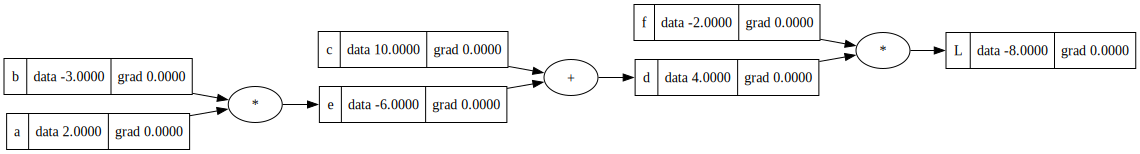

In [ ]:
draw_dot(L)

In [ ]:
# Now we want to start backward propagation. For this, we will start at the end (L) and reverse while calculating the gradient for each value. So we now calculate the derivative of each node with respect to the final output L.
# So we add a grad field which start at 0.0 for each Value node.

L.grad = 1.0 # if you compare L to L + h, and see how much L changes, it changes by h which is 1 time the change in L so 1.0
f.grad = 4.0
d.grad = -2.0
c.grad = -2.0 # in this case, a plus node just carry any change to it's output so the gradient is the same as d
e.grad = -2.0
a.grad = -2.0 * -3.0  # because e = a * b, so de/da = b
b.grad = -2.0 * 2.0   # because e = a


draw_dot(L)

In [ ]:
# to calculate gradient for e and beelow, you can use chain rule:
# If a variable z depend on the variable y, which itself depend on variable x, then the variable z also depend on x via the intermediary variable y. In this case, the chain rule is expressed as :
# dz/dx = dz/dy * dy/dx

In [ ]:
# Now we nudge our model slightly by influence each leaf nodes (thoses we tend to have control over, ie a, b, c, f)
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad
# rerun the forward pass
e = a * b
d = e + c
L = d * f

print(L.data)

-7.286496


In [ ]:
def lol():
    h = 0.001
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    # now do the same as before when we computed d
    e = a * b; e.label='e'
    d = e + c; d.label='d'
    f = Value(-2.0, label='f')
    L = d * f; L.label='L'
    L1 = L.data


    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    b.data += h
    c = Value(10.0, label='c')
    # now do the same as before when we computed d
    e = a * b; e.label='e'
    d = e + c; d.label='d'
    f = Value(-2.0, label='f')
    L = d * f ; L.label='L'
    L2 = L.data

    print((L2-L1)/h)
lol()

# to check the gradient entered above, just change add h to any node once build then check the final result.

-3.9999999999995595


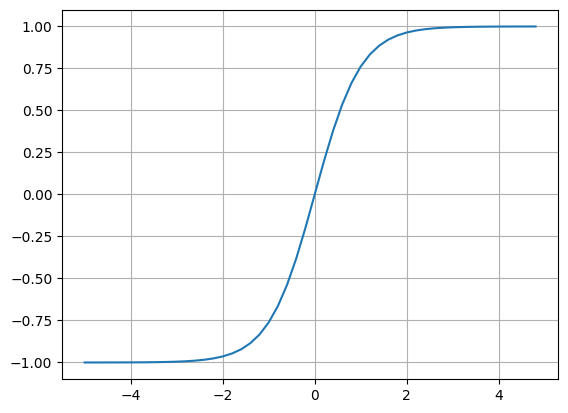

In [ ]:
# A neural network tend to have multiple layers of perceptrons. Each perceptron is just a few of those Value operations chained together. So to build a neural network, we just need to build a bunch of perceptrons and chain them together. Each perceptron will have its own set of weights and biases (which are just Values) that we will update via gradient descent during training.

plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2))); plt.grid()

In [18]:
# input x1 and x2 (2 dimensional neuron)
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights of the neuron
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
x1w1 = x1 * w1; x1w1.label='x1*w1'
x2w2 = x2 * w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label='n'

# now we make the output. For this we need to go back and implement a tahn function in our Value class
output = n.tanh(); output.label='o'
output.backward()

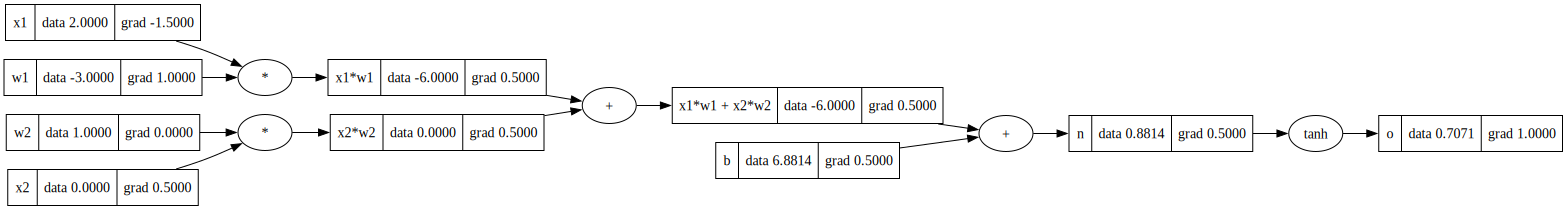

In [19]:
draw_dot(output)

In [ ]:
# Manual backpropagation before implement the .backward() method in the Value class
# let's backpropagate through the expression graph to compute all the gradients
output.grad = 1.0
# now backward through the tanh
n.grad = (1 - output.data**2) * output.grad
# + just propagate the gradient further downwards
x1w1x2w2.grad = n.grad
b.grad = n.grad
x1w1.grad = x1w1x2w2.grad
x2w2.grad = x1w1x2w2.grad
# * nodes use the other input to scale the gradient
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad
# we can now see that w2 has 0 gradient so changing it won't impact the output

In [ ]:
# Topological sort. This method will check a value if it wasn't visited, it mark it as visited then call itself on each of the value's children, then later append the value to the topo list. This is added to the Value model.
topo = []
visited = []
def build_topo(v):
    if v not in visited:
        visited.append(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(output)
topo

[Value(data=6.881373587019543),
 Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=0.0),
 Value(data=-6.0),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

In [ ]:
output.grad = 1.0
output.backward()

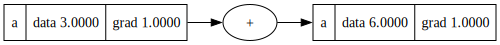

In [ ]:
# We have a bad bug who hasn't surface because the necessary situation hasn't happened yet.

a = Value(3.0, label='a')
b = a + a; b.label = 'a'
b.backward()
draw_dot(b)
# The gradient of 1 for a is actually incorect. The reason is because if b = a + a then the derivative should be 2 (since a = 1)

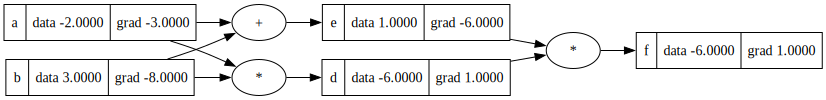

In [ ]:
# Another way to see it with a more complex expression
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b; d.label='d'
e = a + b; e.label='e'
f = d * e; f.label='f'
f.backward()
draw_dot(f)
# Here the gradient of a and b are incorrect. 
# We get an error as soon as a Value is used more than once. The reason is because our calcul of the gradient overwrite the previous value instead of accumulating it. (Check the multivariable case in the wikipedia article on the derivative)
# So we change the method from self.grad =  to self.grad += in each _backward function in the Value class.

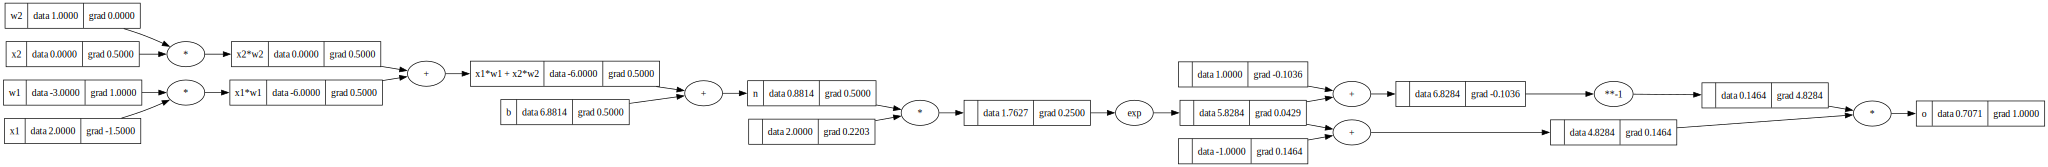

In [20]:
# Copy of above but we change how we implemente output node. We break the tanh (but still mathematical equivalence)
# 2 reasons : practice a few more operations
# - the level in which we implement the operations is up to us. We can implement backward pass for tiny operations like plus or times or we can implement it for tanh. All that matter is that there are input and output. It doesn't matter if the operations are complex or not. 
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735870195432, label='b')
x1w1 = x1 * w1; x1w1.label='x1*w1'
x2w2 = x2 * w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label='n'
# ----
e = (2*n).exp()
output = (e - 1)/ (e + 1)
# ----
output.label='o'
output.backward()
draw_dot(output)

In [21]:
# This is an example of using a modern library api. In this case, we use PyTorch
# Micrograd only allow integer and float. but in PyTorch, everything work around Tensor. by default, you would use more complex one such as torch.Tensor([1, 2, 3], [4, 5, 6]), a 2x3 array
import torch

# double() so it uses float64 rather than the default float32. .requires_grad because by default pytorch believe that leaf nodes do not requires gradient.
x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True
n = x1*w1 + x2*w2 + b
output = torch.tanh(n)

print(output.data.item())
output.backward()

print('----')
print('x2: ', x2.grad.item())
print('w2: ', w2.grad.item())
print('x1: ', x1.grad.item())
print('w1: ', w1.grad.item())

0.7071066904050358
----
x2:  0.5000001283844369
w2:  0.0
x1:  -1.5000003851533106
w1:  1.0000002567688737


In [ ]:
# Now that we made the machinery to build out complicated mathematical expression, we can build our neural network. Neural net are just as specific class of mathematical expressions.

In [22]:
class Neuron:
    # nin = number of neurons as input
    def __init__(self, nin):
        # w = weight for each inputs
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        # b = bias that control the overal "trigger happiness"
        self.b = Value(random.uniform(-1,1))

    # self(childs)
    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
x = [2.0, 3.0]
n = Neuron(2)
n(x)

Value(data=-0.9877925305172498)

In [23]:
# Now we make a layer of neurons (as set of neuron evaluated independantly). It takes the dimension of neurons and the amount of neurons
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
        # outs = []
        # for neuron in self.neurons:
        #     neuron_params = neuron.parameters()
        #     outs.extend(neuron_params)
        # return outs
    
x = [2.0, 3.0]
n = Layer(2,3)
n(x)

[Value(data=-0.9720418393695802),
 Value(data=-0.6739518355221377),
 Value(data=0.8251070355213483)]

In [24]:
# Now we build a multi layer perceptron (MLP)
class MLP:
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [25]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.7043506478722662)

In [26]:
n.parameters()

[Value(data=0.14112833747590514),
 Value(data=-0.9295377064213071),
 Value(data=-0.24036166622701027),
 Value(data=0.2597957071330139),
 Value(data=-0.18806884178017302),
 Value(data=-0.6846375403542349),
 Value(data=0.43967261298223836),
 Value(data=-0.6824908282783826),
 Value(data=0.2250046960265637),
 Value(data=0.23196044140826788),
 Value(data=0.33436770137462424),
 Value(data=0.04146516736413863),
 Value(data=-0.9517198197229924),
 Value(data=0.42812327385570415),
 Value(data=0.5063654140036669),
 Value(data=0.16966684935742848),
 Value(data=0.6966203300795437),
 Value(data=-0.882266137871313),
 Value(data=0.35828572979164197),
 Value(data=-0.09475074499423308),
 Value(data=-0.7755876359797385),
 Value(data=0.4887392234747814),
 Value(data=0.7705057782419171),
 Value(data=0.22578704706386765),
 Value(data=0.1314664421754248),
 Value(data=-0.9209689377472925),
 Value(data=0.6883977283796963),
 Value(data=0.9118583653215655),
 Value(data=0.7750090255699511),
 Value(data=-0.8759553

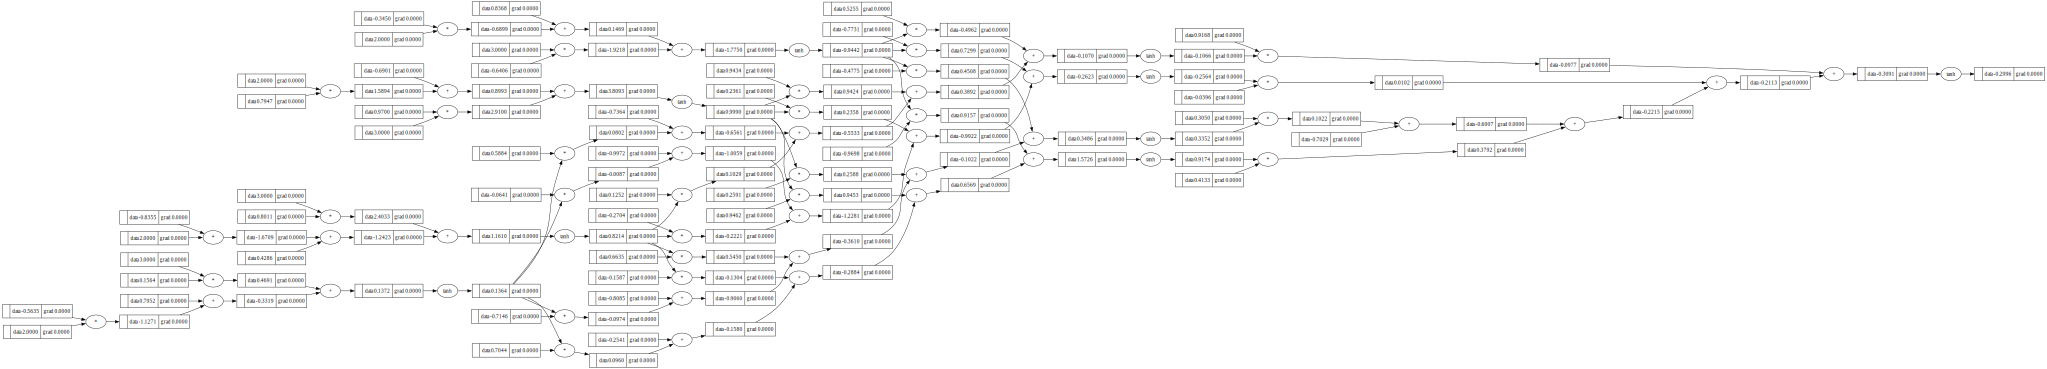

In [ ]:
draw_dot(n(x))

In [38]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.3040120416379288)

In [39]:
# let's create a simple data set with four inputs
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [73]:
lr = 0.1
for k in range(50):
    ypred = [n(x) for x in xs]
    losses = [(yout - ygt)**2 for ygt, yout in zip(ys, ypred)]
    loss = sum(losses, start=Value(0.0))
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
    for p in n.parameters():
        p.data += -lr * p.grad
    print(k, loss.data)

0 0.0019596562107168165
1 0.001949770135435893
2 0.001939979361529503
3 0.0019302825379593404
4 0.0019206783389025572
5 0.0019111654631691203
6 0.0019017426336352008
7 0.001892408596692095
8 0.0018831621217101186
9 0.0018740020005171324
10 0.001864927046891091
11 0.0018559360960662612
12 0.0018470280042526654
13 0.001838201648168365
14 0.0018294559245841135
15 0.0018207897498800807
16 0.001812202059614238
17 0.001803691808102045
18 0.0017952579680071208
19 0.001786899529942548
20 0.001778615502082468
21 0.0017704049097837305
22 0.0017622667952172143
23 0.0017542002170085579
24 0.0017462042498880873
25 0.0017382779843495516
26 0.0017304205263175242
27 0.0017226309968230995
28 0.0017149085316877587
29 0.0017072522812151118
30 0.0016996614098902698
31 0.0016921350960866263
32 0.0016846725317799386
33 0.0016772729222693482
34 0.0016699354859052251
35 0.001662659453823696
36 0.0016554440696874928
37 0.0016482885894331823
38 0.0016411922810243562
39 0.001634154424210852
40 0.0016271743102935